<a href="https://colab.research.google.com/github/issam9/finetuning-bert-models-for-arabic-dialect-detection/blob/main/finetune_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning Arabert, Dziribert and Bert Arabic for Dialect Detection

In [1]:
!nvidia-smi

Sat Oct 16 20:00:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/aub-mind/arabert.git

Cloning into 'arabert'...
remote: Enumerating objects: 552, done.
remote: Counting objects: 100% (338/338), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 552 (delta 180), reused 239 (delta 89), pack-reused 214
Receiving objects: 100% (552/552), 9.15 MiB | 23.97 MiB/s, done.
Resolving deltas: 100% (303/303), done.


In [3]:
!pip install -q transformers
!pip install -q datasets
!pip install -q wandb
!pip install -q farasapy
!pip install -q pyarabic
!pip install -q emoji

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 3.3 MB 46.9 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
     |████████████████████████████████| 895 kB 39.1 MB/s 
     |████████████████████████████████| 287 kB 5.5 MB/s 
     |████████████████████████████████| 125 kB 40.7 MB/s 
     |████████████████████████████████| 243 kB 44.6 MB/s 
     |████████████████████████████████| 1.3 MB 39.4 MB/s 
     |████████████████████████████████| 160 kB 33.4 MB/s 
     |████████████████████████████████| 271 kB 47.6 MB/s 
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 180 kB 43.2 MB/s 
     |████████████████████████████████| 139 kB 42.1 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 126 kB 5.2 MB/s 
     |██████████████████

In [4]:
import pandas as pd 

from sklearn.model_selection import train_test_split

from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [5]:
# mount colab
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = Path('/content/drive/MyDrive/ml/projects/msda_dataset/dialect')

In [7]:
df = pd.read_csv(path/'dialect.csv')
df.head()

,Twits,dialect
0,الدكتورة نجوى قامة في القصف الصاروخي لك ان ترى...,Algerian
1,سكيكدة_المجاهدة❤ صورة تجمع أحد أكبر و أعظم زعم...,Algerian
2,😂😂😂😂😂 شكون يعرفها🤔,Algerian
3,يهود الأندلس للاسف جاو زرعوا الفتنة في وسطنا,Algerian
4,اليهود,Algerian


In [8]:
df['dialect'].value_counts()

Lebanon     14482
Algerian    13393
Morocco      9965
Tunisian     8044
egypt        7519
Name: dialect, dtype: int64

In [9]:
dialects = df['dialect'].unique()

lbl2idx = {d: i for i, d in enumerate(dialects)}

df['dialect'] = df['dialect'].map(lbl2idx)

In [10]:
df['dialect'].unique()

array([0, 1, 2, 3, 4])

In [11]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Twits'], df['dialect'], random_state=42, 
                                                                    test_size=0.3)

val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, random_state=42, 
                                                                test_size=0.5)

len(train_texts), len(val_texts), len(test_texts)

(37382, 8010, 8011)

### Finetuning arabert

In [13]:
from arabert.preprocess import ArabertPreprocessor

bert_model = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=bert_model)

text = train_texts[0]
prep_text = arabert_prep.preprocess(text)
prep_text

[2021-10-16 20:03:17,605 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


'ال+ دكتور +ة نجوى قام +ة في ال+ قصف ال+ صاروخي ل+ +ك ان ترى منشور +ات +ها و+ تدخل +ات +ها'

In [14]:
BERT_MODEL_NAME = 'aubmindlab/bert-base-arabertv02-twitter'
bert = AutoModel.from_pretrained(BERT_MODEL_NAME)

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/667 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dens

Downloading:   0%|          | 0.00/733k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476 [00:00<?, ?B/s]

In [15]:
# encode text
tokenizer.batch_encode_plus([prep_text], padding=True, return_token_type_ids=False)

{'input_ids': [[2, 298, 17, 15278, 17, 114, 28575, 1178, 17, 114, 305, 298, 17, 9302, 298, 17, 46434, 135, 17, 17, 134, 338, 4989, 35985, 17, 682, 17, 3824, 139, 17, 3403, 17, 682, 17, 3824, 3]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

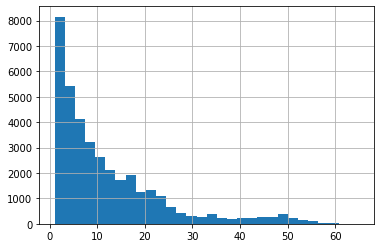

In [16]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_texts]

pd.Series(seq_len).hist(bins = 30)

In [17]:
max_seq_len = 25

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

In [19]:
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [20]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [21]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0]),
 'input_ids': tensor([    2, 23789,  4683,  7195,   225,  4129,  8531,  5049,   533,  7174,
          1155, 12629, 37260,   394, 13119, 12155,  9446,   558, 33956, 24732,
          8643, 17506,     3,     0,     0]),
 'labels': tensor(0),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0])}

In [22]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# function to pass to out trainer in order to compute accuracy, f1 score, precision and recall
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [23]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    report_to='wandb'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

***** Running training *****
  Num examples = 37382
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5845
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.570500,0.549116,0.794881,0.794881,0.794881,0.794881
2,0.377100,0.549318,0.807740,0.807740,0.807740,0.807740
3,0.252900,0.560557,0.820974,0.820974,0.820974,0.820974
4,0.194800,0.657808,0.817978,0.817978,0.817978,0.817978
5,0.095000,0.753014,0.824469,0.824469,0.824469,0.824469


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in 

TrainOutput(global_step=5845, training_loss=0.34359780259373046, metrics={'train_runtime': 2364.4594, 'train_samples_per_second': 79.05, 'train_steps_per_second': 2.472, 'total_flos': 2401338476950500.0, 'train_loss': 0.34359780259373046, 'epoch': 5.0})

In [24]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8011
  Batch size = 64


PredictionOutput(predictions=array([[-1.5914751 ,  0.5279801 , -2.0416894 ,  5.476267  , -2.8722367 ],
       [-1.2690709 , -1.6008068 , -2.644433  ,  7.8108873 , -2.3719149 ],
       [-1.870421  ,  3.7449    , -4.3165646 , -2.08716   ,  4.7042146 ],
       ...,
       [-0.8168961 , -0.6052444 , -1.9599562 ,  6.201586  , -2.9561734 ],
       [-0.31812266,  0.4615853 ,  0.28369105,  0.22800362, -0.48732403],
       [ 7.8046823 , -2.3626525 , -1.0180012 , -2.0554988 , -2.0392506 ]],
      dtype=float32), label_ids=array([1, 3, 4, ..., 3, 3, 0]), metrics={'test_loss': 0.7647235989570618, 'test_accuracy': 0.8279865185370117, 'test_f1': 0.8279865185370117, 'test_precision': 0.8279865185370117, 'test_recall': 0.8279865185370117, 'test_runtime': 23.9761, 'test_samples_per_second': 334.124, 'test_steps_per_second': 5.255})

### Finetuning dziribert

In [12]:
BERT_MODEL_NAME = 'alger-ia/dziribert'

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of the model checkpoint at alger-ia/dziribert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/176 [00:00<?, ?B/s]

In [14]:
max_seq_len = 25

In [15]:
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [20]:
train_encodings[0]

Encoding(num_tokens=25, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [16]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [18]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    evaluation_strategy='epoch',
    report_to='wandb'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

***** Running training *****
  Num examples = 37382
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5845
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.544600,0.470259,0.830087,0.830087,0.830087,0.830087
2,0.319100,0.489107,0.832834,0.832834,0.832834,0.832834
3,0.150900,0.622314,0.840200,0.840200,0.840200,0.840200
4,0.076500,0.850390,0.839201,0.839201,0.839201,0.839201
5,0.038500,0.887370,0.845568,0.845568,0.845568,0.845568


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in 

TrainOutput(global_step=5845, training_loss=0.25069988110414215, metrics={'train_runtime': 2464.9131, 'train_samples_per_second': 75.828, 'train_steps_per_second': 2.371, 'total_flos': 2401338476950500.0, 'train_loss': 0.25069988110414215, 'epoch': 5.0})

In [19]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8011
  Batch size = 64


PredictionOutput(predictions=array([[-2.3625293 ,  7.935675  , -1.4187776 , -1.5907899 , -2.634851  ],
       [-0.8095739 , -2.029526  , -2.7067924 ,  7.8290257 , -1.9284828 ],
       [-2.325295  , -1.8311379 , -3.689361  ,  0.12742263,  6.686925  ],
       ...,
       [-1.3125819 ,  1.6767278 , -1.3233855 ,  5.494418  , -4.1050167 ],
       [-1.0637516 , -2.4735856 ,  3.1865199 ,  0.7601345 , -0.7705013 ],
       [ 8.165027  , -2.139205  , -1.5214015 , -2.3346906 , -2.413062  ]],
      dtype=float32), label_ids=array([1, 3, 4, ..., 3, 3, 0]), metrics={'test_loss': 0.8822937607765198, 'test_accuracy': 0.8428410934964424, 'test_f1': 0.8428410934964424, 'test_precision': 0.8428410934964424, 'test_recall': 0.8428410934964424, 'test_runtime': 25.9654, 'test_samples_per_second': 308.526, 'test_steps_per_second': 4.853})

### Finetuning bert-base-arabic

In [12]:
BERT_MODEL_NAME = 'asafaya/bert-base-arabic'

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-ar

In [14]:
max_seq_len = 25

In [15]:
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [16]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [18]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    # report_to='wandb'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

***** Running training *****
  Num examples = 37382
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5845
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: issam1 (use `wandb login --relogin` to force relogin)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.827000,0.600420,0.768539,0.768539,0.768539,0.768539
2,0.455100,0.603596,0.786142,0.786142,0.786142,0.786142
3,0.258900,0.670925,0.802497,0.802497,0.802497,0.802497
4,0.148900,0.811274,0.802247,0.802247,0.802247,0.802247
5,0.089900,0.990216,0.809863,0.809863,0.809863,0.809863


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in 

TrainOutput(global_step=5845, training_loss=0.3559465811332135, metrics={'train_runtime': 2341.6719, 'train_samples_per_second': 79.819, 'train_steps_per_second': 2.496, 'total_flos': 2401338476950500.0, 'train_loss': 0.3559465811332135, 'epoch': 5.0})

In [19]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8011
  Batch size = 64


PredictionOutput(predictions=array([[-2.9203129e+00,  7.3646150e+00, -1.6223066e+00, -1.0767794e+00,
        -2.0874398e+00],
       [-9.3266536e-03,  6.7047328e-01, -2.6485603e+00,  5.6929898e+00,
        -2.5990424e+00],
       [-1.9154329e+00, -5.7758558e-01, -2.4327574e+00, -1.8282853e+00,
         7.1013899e+00],
       ...,
       [-2.8917902e+00,  4.9016080e+00, -2.2455933e+00,  3.4851663e+00,
        -2.7986975e+00],
       [ 6.4562649e-02,  6.3554816e-02, -1.3950185e-03, -9.4588082e-03,
        -4.7639567e-01],
       [ 7.3927207e+00, -2.8901663e+00, -2.1047127e+00, -2.2497656e+00,
        -2.1236787e+00]], dtype=float32), label_ids=array([1, 3, 4, ..., 3, 3, 0]), metrics={'test_loss': 0.9903667569160461, 'test_accuracy': 0.8103857196355012, 'test_f1': 0.8103857196355013, 'test_precision': 0.8103857196355012, 'test_recall': 0.8103857196355012, 'test_runtime': 25.9317, 'test_samples_per_second': 308.927, 'test_steps_per_second': 4.859})